# Use OSMnx to create and analyze a NetworkX street network

OSMnx is a Python library that lets you download spatial geometries and construct, project, and visualize street networks from OpenStreetMap's API.

More about OSMnx: https://github.com/gboeing/osmnx

Install OSMnx: `pip install osmnx`

*Windows users*: install [geopandas](http://geoffboeing.com/2014/09/using-geopandas-windows/) and its dependencies (including rtree) first, before OSMnx

In [1]:
import osmnx as ox, networkx as nx, pandas as pd
%matplotlib inline
ox.config(log_console=True, use_cache=True)

## Calculate basic (and more advanced) street network metrics

In [2]:
# get the network for Piedmont, calculate its basic stats, then show the average circuity
stats = ox.basic_stats(ox.graph_from_place('Piedmont, California, USA', network_type='drive_service'))

In [3]:
stats

{'circuity_avg': 1.1187405730945883,
 'edge_density_km': None,
 'edge_length_avg': 119.33970967515528,
 'edge_length_total': 116475.55664295155,
 'k_avg': 5.392265193370166,
 'm': 976,
 'n': 362,
 'node_density_km': None,
 'self_loop_proportion': 0.006147540983606557,
 'street_density_km': None,
 'street_length_avg': 119.34173991190751,
 'street_length_total': 60506.26213533711,
 'street_segments_count': 507,
 'streets_per_intersection_avg': 2.914364640883978,
 'streets_per_intersection_counts': {0: 0,
  1: 41,
  2: 2,
  3: 269,
  4: 48,
  5: 1,
  6: 1},
 'streets_per_intersection_proportion': {0: 0.0,
  1: 0.1132596685082873,
  2: 0.0055248618784530384,
  3: 0.7430939226519337,
  4: 0.13259668508287292,
  5: 0.0027624309392265192,
  6: 0.0027624309392265192}}

In [4]:
stats['circuity_avg']

1.1187405730945883

To calculate density-based metrics, you must also pass the network's bounding area in square meters (otherwise `basic_stats()` will just skip them in the calculation):

In [5]:
# get the street network for a place, and its area in square meters (by projecting)
place = 'Piedmont, California, USA'
gdf = ox.gdf_from_place(place)
area = ox.project_gdf(gdf).unary_union.area
G = ox.graph_from_place(place, network_type='drive_service')

In [6]:
# calculate basic and extended network stats, merge them together, and display
stats = ox.basic_stats(G, area=area)
extended_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True)
for key, value in extended_stats.items():
    stats[key] = value
pd.Series(stats)

avg_clustering_coefficient_weighted                                           0.00890992
avg_neighbor_degree                    {53107192: 2.6666666666666665, 53090322: 3.0, ...
avg_neighbor_degree_avg                                                          2.89526
avg_weighted_neighbor_degree           {53107192: 0.019179456801477934, 53090322: 0.0...
avg_weighted_neighbor_degree_avg                                               0.0328517
betweenness_centrality                 {53092207: 0.0052746749179152985, 53107192: 0....
betweenness_centrality_avg                                                     0.0391729
center                                                                       [305541020]
circuity_avg                                                                     1.11874
closeness_centrality                   {53092207: 0.0005215515636372697, 53107192: 0....
closeness_centrality_avg                                                     0.000595247
clustering_coefficien

Notice that this returns the basic stats as a dict, which we threw into a pandas series. Degree counts and proportions are nested dicts inside it. To convert these stats to a pandas dataframe (to compare/analyze multiple networks against each other), just unpack these nested dicts first:

In [7]:
# unpack dicts into individiual keys:values
stats = ox.basic_stats(G, area=area)
for k, count in stats['streets_per_intersection_counts'].items():
    stats['int_{}_count'.format(k)] = count
for k, proportion in stats['streets_per_intersection_proportion'].items():
    stats['int_{}_prop'.format(k)] = proportion

# delete the no longer needed dict elements
del stats['streets_per_intersection_counts']
del stats['streets_per_intersection_proportion']

# load as a pandas dataframe
pd.DataFrame(pd.Series(stats)).T

,circuity_avg,edge_density_km,edge_length_avg,edge_length_total,int_0_count,int_0_prop,int_1_count,int_1_prop,int_2_count,int_2_prop,...,k_avg,m,n,node_density_km,self_loop_proportion,street_density_km,street_length_avg,street_length_total,street_segments_count,streets_per_intersection_avg
0,1.118741,26797.725362,119.33971,116475.556643,0.0,0.0,41.0,0.11326,2.0,0.005525,...,5.392265,976.0,362.0,83.285943,0.006148,13920.776531,119.34174,60506.262135,507.0,2.914365


In [8]:
# proportion of intersections that are cul-de-sacs, T-intersections, and X-intersections?
print(stats['int_1_prop'])
print(stats['int_3_prop'])
print(stats['int_4_prop'])

0.1132596685082873
0.7430939226519337
0.13259668508287292


In [9]:
# how many streets emanate from each intersection?
G.graph['streets_per_intersection']

{53017091: 3,
 53018397: 3,
 53018399: 3,
 53018402: 3,
 53018404: 3,
 53018410: 3,
 53018411: 3,
 53021742: 4,
 53021743: 3,
 53021750: 3,
 53022623: 3,
 53022625: 1,
 53023513: 3,
 53025057: 3,
 53025060: 3,
 53025220: 3,
 53025222: 1,
 53027454: 3,
 53027455: 3,
 53027457: 4,
 53027459: 3,
 53027461: 3,
 53027463: 3,
 53028190: 3,
 53028192: 4,
 53033660: 4,
 53035699: 4,
 53036557: 3,
 53036558: 6,
 53037306: 3,
 53037307: 3,
 53040495: 4,
 53040794: 3,
 53041432: 3,
 53041437: 3,
 53041440: 3,
 53041442: 4,
 53041443: 4,
 53041445: 3,
 53041668: 3,
 53041670: 1,
 53042706: 3,
 53042707: 3,
 53044573: 1,
 53044575: 3,
 53044661: 3,
 53044664: 3,
 53046249: 3,
 53046250: 3,
 53046251: 3,
 53046252: 3,
 53046253: 3,
 53046254: 3,
 53046255: 4,
 53050874: 3,
 53050875: 3,
 53057697: 4,
 53057704: 3,
 53059166: 3,
 53059173: 4,
 53059175: 3,
 53059186: 3,
 53059187: 3,
 53059189: 3,
 53059885: 3,
 53060462: 3,
 53060465: 3,
 53060466: 4,
 53060467: 3,
 53060468: 4,
 53060469: 4,
 53060

## What's inside a NetworkX graph?

In [10]:
# nodes
G.nodes(data=True)

[(53092207, {'osmid': 53092207, 'x': -122.2264515, 'y': 37.8155155}),
 (53090322, {'osmid': 53090322, 'x': -122.2368032, 'y': 37.8204243}),
 (53017091, {'osmid': 53017091, 'x': -122.2476037, 'y': 37.8262501}),
 (53068822, {'osmid': 53068822, 'x': -122.2340514, 'y': 37.8188938}),
 (53068826, {'osmid': 53068826, 'x': -122.2322533, 'y': 37.8174977}),
 (53142555, {'osmid': 53142555, 'x': -122.2340241, 'y': 37.8304544}),
 (53068829, {'osmid': 53068829, 'x': -122.2332175, 'y': 37.8166607}),
 (53041670, {'osmid': 53041670, 'x': -122.2395479, 'y': 37.8287933}),
 (53021742, {'osmid': 53021742, 'x': -122.2303409, 'y': 37.8210859}),
 (53021743, {'osmid': 53021743, 'x': -122.2307834, 'y': 37.8221537}),
 (53144625, {'osmid': 53144625, 'x': -122.2388216, 'y': 37.8305302}),
 (317363251,
  {'highway': 'turning_circle',
   'osmid': 317363251,
   'x': -122.239482,
   'y': 37.8207764}),
 (317295966, {'osmid': 317295966, 'x': -122.2367896, 'y': 37.8210906}),
 (53021750, {'osmid': 53021750, 'x': -122.22951

In [11]:
# edges
G.edges(keys=True, data=True)

[(53092207,
  53092210,
  0,
  {'geometry': <shapely.geometry.linestring.LineString at 0x19f1e805400>,
   'highway': 'residential',
   'length': 142.95143879632437,
   'name': 'La Salle Avenue',
   'oneway': False,
   'osmid': 6353636}),
 (53092207,
  53050874,
  0,
  {'highway': 'residential',
   'length': 184.8626715345085,
   'name': 'Muir Avenue',
   'oneway': False,
   'osmid': 6367509}),
 (53092207,
  53046255,
  0,
  {'geometry': <shapely.geometry.linestring.LineString at 0x19f1e805240>,
   'highway': 'residential',
   'length': 114.28151100234271,
   'name': 'La Salle Avenue',
   'oneway': False,
   'osmid': 6353636}),
 (53107192,
  311882161,
  0,
  {'highway': 'residential',
   'length': 36.57383827967535,
   'name': 'Lower Grand Avenue',
   'oneway': False,
   'osmid': 277456647}),
 (53107192,
  53076245,
  0,
  {'geometry': <shapely.geometry.linestring.LineString at 0x19f1eda7908>,
   'highway': 'residential',
   'length': 314.5998670491188,
   'name': 'Lower Grand Avenue',

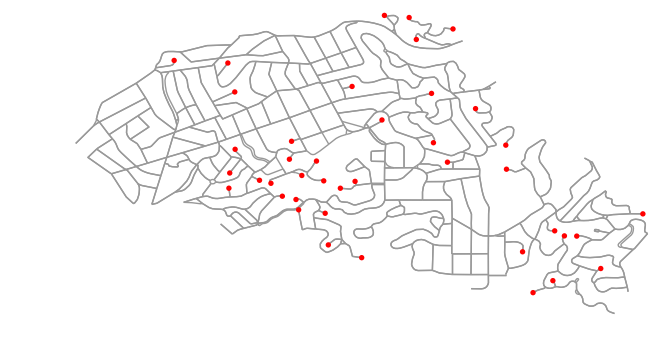

In [12]:
# highlight all the cul-de-sacs
nc = ['r' if G.graph['streets_per_intersection'][node]==1 else 'none' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_zorder=2, fig_height=4)

## Calculate the network path from the centermost node to some other node
Let the origin node be the node nearest the location and let the destination node just be the last node in the network. Then find the shortest path between origin and destination, using weight='length' to find the shortest spatial path (otherwise it treats each edge as weight=1).

In [13]:
# define a lat-long point, create network around point, define origin/destination nodes
location_point = (37.791427, -122.410018)
G = ox.graph_from_point(location_point, distance=500, distance_type='network', network_type='walk')
origin_node = ox.get_nearest_node(G, location_point)
destination_node = G.nodes()[-1]

In [14]:
# find the route between these nodes then plot it
route = nx.shortest_path(G, origin_node, destination_node, weight='length')
route

[65326733, 65326736, 65332818, 65332815, 65319944, 65290756, 65290750]

In [15]:
# inspect the first node in the route
G.node[route[0]]

{'osmid': 65326733, 'x': -122.4107711, 'y': 37.7915424}

http://www.openstreetmap.org/node/65326733

In [16]:
# inspect the first edge in the route
G.edge[route[0]][route[1]]

{0: {'geometry': <shapely.geometry.linestring.LineString at 0x19f1d7106d8>,
  'highway': 'residential',
  'length': 74.15163586589111,
  'name': 'Mason Street',
  'oneway': False,
  'osmid': 27166466}}

http://www.openstreetmap.org/way/27166466

In [17]:
# what is the first edge's length
G.edge[route[0]][route[1]][0]['length']

74.15163586589111

In [18]:
# what is the total length of the route?
nx.shortest_path_length(G, origin_node, destination_node, weight='length')

443.13354620656

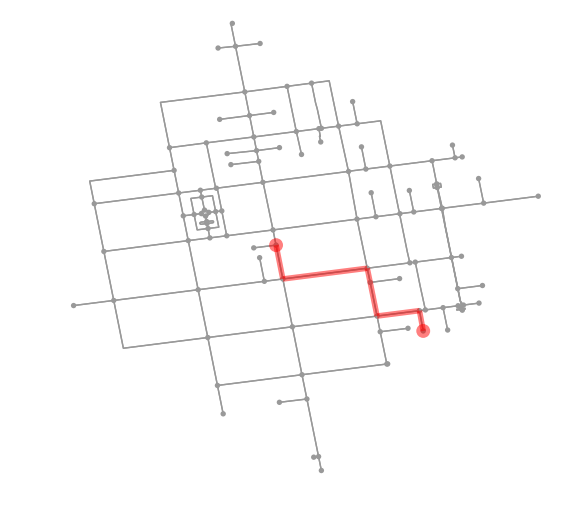

In [19]:
# plot it
fig, ax = ox.plot_graph_route(G, route)

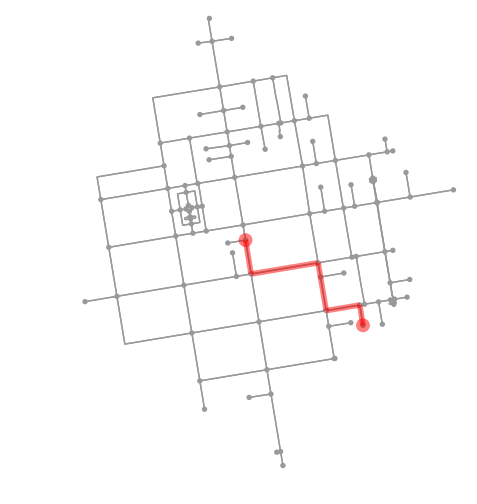

In [20]:
# project the network to UTM (zone calculated automatically) then plot the network/route again
G_proj = ox.project_graph(G)
fig, ax = ox.plot_graph_route(G_proj, route)

## Plot network path from one lat-long to another

In [21]:
# define origin/desination points then get the nodes nearest to each
origin_point = (37.792896, -122.412325)
destination_point = (37.790495, -122.408353)
origin_node = ox.get_nearest_node(G, origin_point)
destination_node = ox.get_nearest_node(G, destination_point)
origin_node, destination_node

(850803362, 65290756)

In [22]:
# find the shortest path between origin and destination nodes
route = nx.shortest_path(G, origin_node, destination_node, weight='length')
str(route)

'[850803362, 633686735, 633686762, 633686748, 633686743, 850803353, 65295320, 65295314, 65295311, 65332818, 65332815, 65319944, 65290756]'

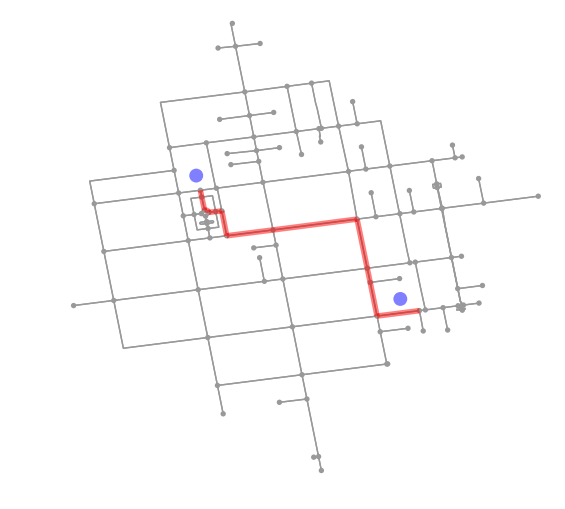

In [23]:
# plot the route showing origin/destination lat-long points in blue
fig, ax = ox.plot_graph_route(G, route, origin_point=origin_point, destination_point=destination_point)

## Demonstrate routing with one-way streets

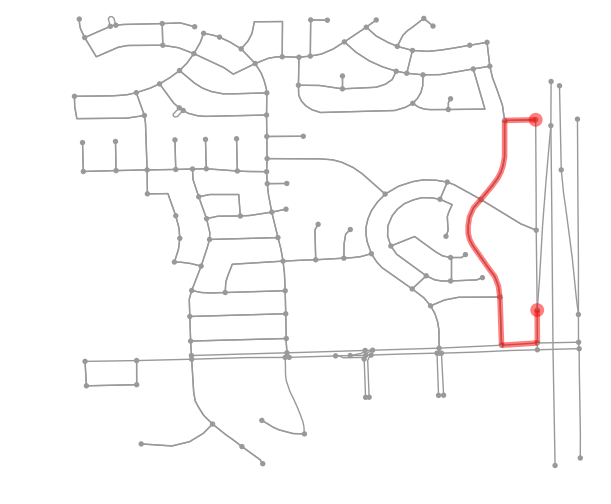

In [24]:
G = ox.graph_from_address('N Sicily Pl, Chandler, Arizona', distance=800, network_type='drive')
origin = (33.307792, -111.894940)
destination = (33.312994, -111.894998)
origin_node = ox.get_nearest_node(G, origin)
destination_node = ox.get_nearest_node(G, destination)
route = nx.shortest_path(G, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G, route, save=True, filename='route')

#### Also, when there are parallel edges between nodes in the route, OSMnx picks the shortest edge to plot

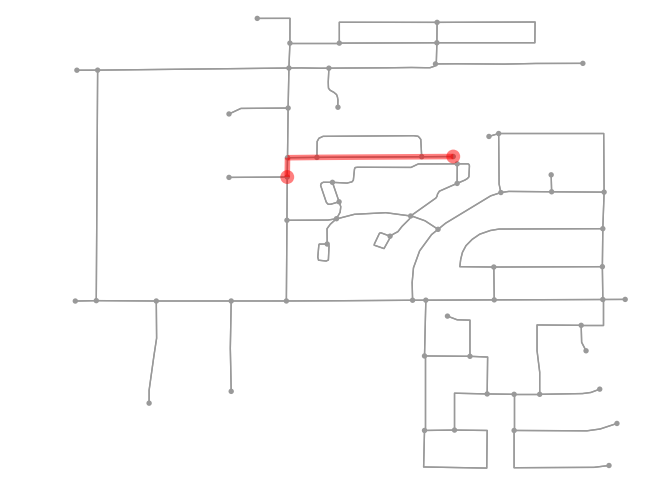

In [25]:
location_point = (33.299896, -111.831638)
G = ox.graph_from_point(location_point, distance=500, clean_periphery=False)
origin = (33.301821, -111.829871)
destination = (33.301402, -111.833108)
origin_node = ox.get_nearest_node(G, origin)
destination_node = ox.get_nearest_node(G, destination)
route = nx.shortest_path(G, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G, route)